In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset

import numpy as np
from matplotlib import pyplot as plt

from src.utils import MNIST, MNIST_v3_fake, train, train_epoch_adv
from src.models import CNN
from src.advattack.attacks import test, plot_examples

from src.utils import train_epoch_adv_v2,train_epoch_adv_v3, test_epoch_adv, train_epoch_default

from src.advattack.FGSM import FGSM
from src.advattack.noising import RandomTransform
from src.advattack.operations import Operations

from src.advattack.initialize_all_attacks import initialize_all_attacks , initialize_all_aggressive_attacks

from copy import deepcopy

from PIL import Image


import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# device = torch.device("mps" if torch.mps.is_available() else "cpu")
device = torch.device("cpu")

## DATA

In [13]:
train_dataset, test_dataset, train_loader, test_loader = MNIST()

## LOAD CHECKPOINT

In [14]:
model = CNN().to(device)
model.load_state_dict(torch.load('./checkpoints/simple_cnn_mnist.pth'))

<All keys matched successfully>

## Experiments

In [15]:
def CombineImagesHorizontally(*images):
    if not images:
        raise ValueError("No images provided")

    total_width = sum(img.width for img in images)
    max_height = max(img.height for img in images)

    combined_image = Image.new('RGB', (total_width, max_height))

    x_offset = 0
    for img in images:
        combined_image.paste(img, (x_offset, 0))
        x_offset += img.width

    return combined_image
def display_images(images, transpose = True):
    M = len(images)
    N = len(images[0])
    if transpose:
        M, N = N, M
    
    fig, axes = plt.subplots(M, N, figsize=(N * 2, M * 2))
    
    for i in range(M):
        for j in range(N):
            ax = axes[i, j]
            if transpose:
                img = images[j][i] 
            else:
                img = images[i][j]
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            
    plt.tight_layout()
    plt.show()
def experiments( all_attacks, model =model):
    all_accuracies = []
    all_examples = []

    for attacks in all_attacks:
        accuracies = []
        examples = []

        for attack in attacks:
            fake_acc, real_acc, ex = test(model, test_loader, attack=attack)
            accuracies.append(fake_acc)
            examples.append(ex)
        
        all_accuracies.append(accuracies)
        all_examples.append(examples)
    return all_accuracies , all_examples

In [15]:

epsilons = [0, .05, .1, .15, .2, .25, .3]
multipliers = [0. , 0.5 , 1.0 , 1.5 , 2.0 , 2.5 , 3.0]

attack_models1 = FGSM(model = model)
attack_models2 = [RandomTransform(rotation_range=(0, 60*mul), noise_mean=0, noise_std=0.2 * mul) for mul in multipliers ]

attacks1 = [lambda x, y, eps=eps: attack_models1.fgsm_augment(x, y, eps) for eps in epsilons]
attacks2 = [lambda x,y, attack_model=attack_model: attack_model.apply_transforms(x,y) for attack_model in attack_models2]

all_atacks = [
    attacks1, 
    attacks2,
]

In [69]:
all_accuracies , all_examples = experiments(all_atacks)

  0%|          | 0/157 [00:00<?, ?it/s]

100%|██████████| 157/157 [00:11<00:00, 13.20it/s]


Real Accuracy = 0.9814888535031847, Fake Accuracy on the real true predictions = 1.0


100%|██████████| 157/157 [00:10<00:00, 15.03it/s]


Real Accuracy = 0.9814888535031847, Fake Accuracy on the real true predictions = 0.9301959452436601


100%|██████████| 157/157 [00:13<00:00, 11.67it/s]


Real Accuracy = 0.9814888535031847, Fake Accuracy on the real true predictions = 0.7610354358235254


100%|██████████| 157/157 [00:12<00:00, 12.45it/s]


Real Accuracy = 0.9814888535031847, Fake Accuracy on the real true predictions = 0.5100999197881212


100%|██████████| 157/157 [00:10<00:00, 14.32it/s]


Real Accuracy = 0.9814888535031847, Fake Accuracy on the real true predictions = 0.24543620945726363


100%|██████████| 157/157 [00:11<00:00, 13.46it/s]


Real Accuracy = 0.9814888535031847, Fake Accuracy on the real true predictions = 0.09027234758547378


100%|██████████| 157/157 [00:10<00:00, 14.65it/s]


Real Accuracy = 0.9814888535031847, Fake Accuracy on the real true predictions = 0.03782871519677066


100%|██████████| 157/157 [00:11<00:00, 13.55it/s]


Real Accuracy = 0.9814888535031847, Fake Accuracy on the real true predictions = 1.0


100%|██████████| 157/157 [00:13<00:00, 11.28it/s]


Real Accuracy = 0.9814888535031847, Fake Accuracy on the real true predictions = 0.9748493196895771


100%|██████████| 157/157 [00:14<00:00, 10.97it/s]


Real Accuracy = 0.9814888535031847, Fake Accuracy on the real true predictions = 0.8752315967968104


100%|██████████| 157/157 [00:13<00:00, 11.77it/s]


Real Accuracy = 0.9814888535031847, Fake Accuracy on the real true predictions = 0.7387064618342212


100%|██████████| 157/157 [00:08<00:00, 19.48it/s]


Real Accuracy = 0.9814888535031847, Fake Accuracy on the real true predictions = 0.5774656525709816


100%|██████████| 157/157 [00:07<00:00, 19.63it/s]


Real Accuracy = 0.9814888535031847, Fake Accuracy on the real true predictions = 0.45447627865463586


100%|██████████| 157/157 [00:13<00:00, 11.66it/s]

Real Accuracy = 0.9814888535031847, Fake Accuracy on the real true predictions = 0.37350908007826006


In [70]:
# plot_examples(vvalues = epsilons, examples=all_examples[0], cnt_ex = 6 )
# plot_examples(vvalues = multipliers, examples=all_examples[1], cnt_ex = 6 )

## AUGMENTATION finetuning Adversarial loss

### Pretrained model

In [6]:
model = CNN().to(device)
model.load_state_dict(torch.load('./checkpoints/simple_cnn_mnist.pth'))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

next(model.parameters()).device

device(type='cpu')

In [7]:
eps = 0.1
mul = 1.5
attack_model1 = FGSM(model = model)
attack_model2 = RandomTransform(rotation_range=(0, 60*mul), noise_mean=0, noise_std=0.2 * mul)

attacks = [
    lambda x, y, eps=eps: attack_models1.fgsm_augment(x, y, eps) ,
    lambda x,y, attack_model=attack_model2: attack_model.apply_transforms(x,y)
]


In [41]:
n = len(attacks)
pi = torch.ones(n)/n
pi.to(device)
pi, pi_array = train_epoch_adv(model, pi, attacks, optimizer, train_loader, criterion, device, tau =1)
torch.save(model.state_dict(), './checkpoints/simple_cnn_mnist_adversarial_2attacks.pth')

  0%|          | 0/938 [00:00<?, ?it/s]

100%|██████████| 938/938 [00:23<00:00, 39.45it/s]


In [36]:
pi

tensor([0.5452, 0.4548])

### load adv model

In [22]:
model = CNN().to(device)
model.load_state_dict(torch.load('./checkpoints/simple_cnn_mnist_adversarial_2attacks.pth'))

<All keys matched successfully>

In [ ]:
next(model.parameters()).device

device(type='mps', index=0)

In [76]:
all_accuracies_adv , all_examples_adv = experiments(all_atacks, model=model)

100%|██████████| 157/157 [00:14<00:00, 10.73it/s]


Real Accuracy = 0.9830812101910829, Fake Accuracy on the real true predictions = 1.0


100%|██████████| 157/157 [00:17<00:00,  8.99it/s]


Real Accuracy = 0.9830812101910829, Fake Accuracy on the real true predictions = 0.9875012761105753


100%|██████████| 157/157 [00:17<00:00,  8.85it/s]


Real Accuracy = 0.9830812101910829, Fake Accuracy on the real true predictions = 0.9697818771270797


100%|██████████| 157/157 [00:12<00:00, 13.05it/s]


Real Accuracy = 0.9830812101910829, Fake Accuracy on the real true predictions = 0.9411307012191067


 39%|███▉      | 61/157 [00:05<00:11,  8.63it/s]

## Сравнение моделей

Text(0, 0.5, 'Accuracy')

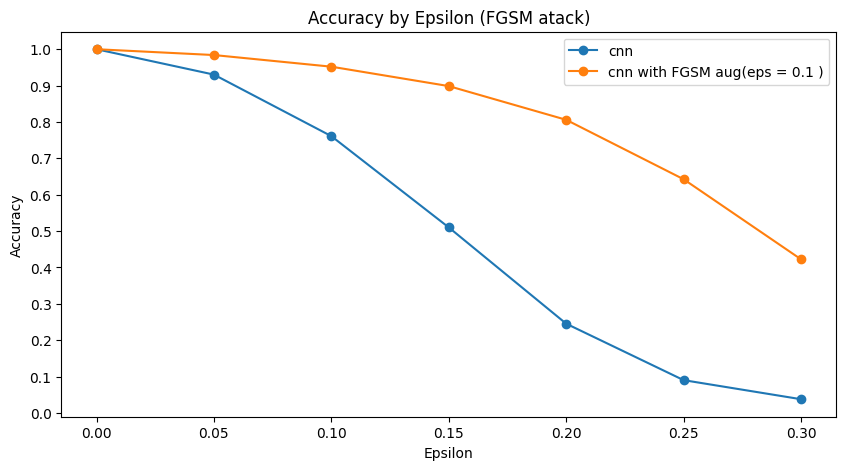

In [71]:
plt.figure(figsize=(10,5))
plt.plot(epsilons, all_accuracies[0],'-o', label = 'cnn')
plt.plot(epsilons, all_accuracies_adv[0],'-o', label = 'cnn with adversarial')
plt.title("Accuracy by Epsilon (FGSM attack)")
plt.legend()
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")

plt.figure(figsize=(10,5))
plt.plot(multipliers, all_accuracies[1],'-o', label = 'cnn')
plt.plot(multipliers, all_accuracies_adv[1],'-o', label = 'cnn with adversarial')
plt.title("Accuracy by multiplier (noise + rotate attack)")
plt.legend()
plt.xlabel("Multipliers")
plt.ylabel("Accuracy")

## Adversatial training

### model

In [8]:
model = CNN().to(device)
model.load_state_dict(torch.load('./checkpoints/simple_cnn_mnist.pth'))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(next(model.parameters()).device)

attacks = initialize_all_aggressive_attacks(model)[:9]
n = len(attacks)
n

cpu


9

## Visualize attacks

In [20]:
operations = Operations()
for elem in train_loader:
    image, label = elem
    break
augs = [operations.tensors_to_images(attack(image,label))[:4] for attack in attacks]


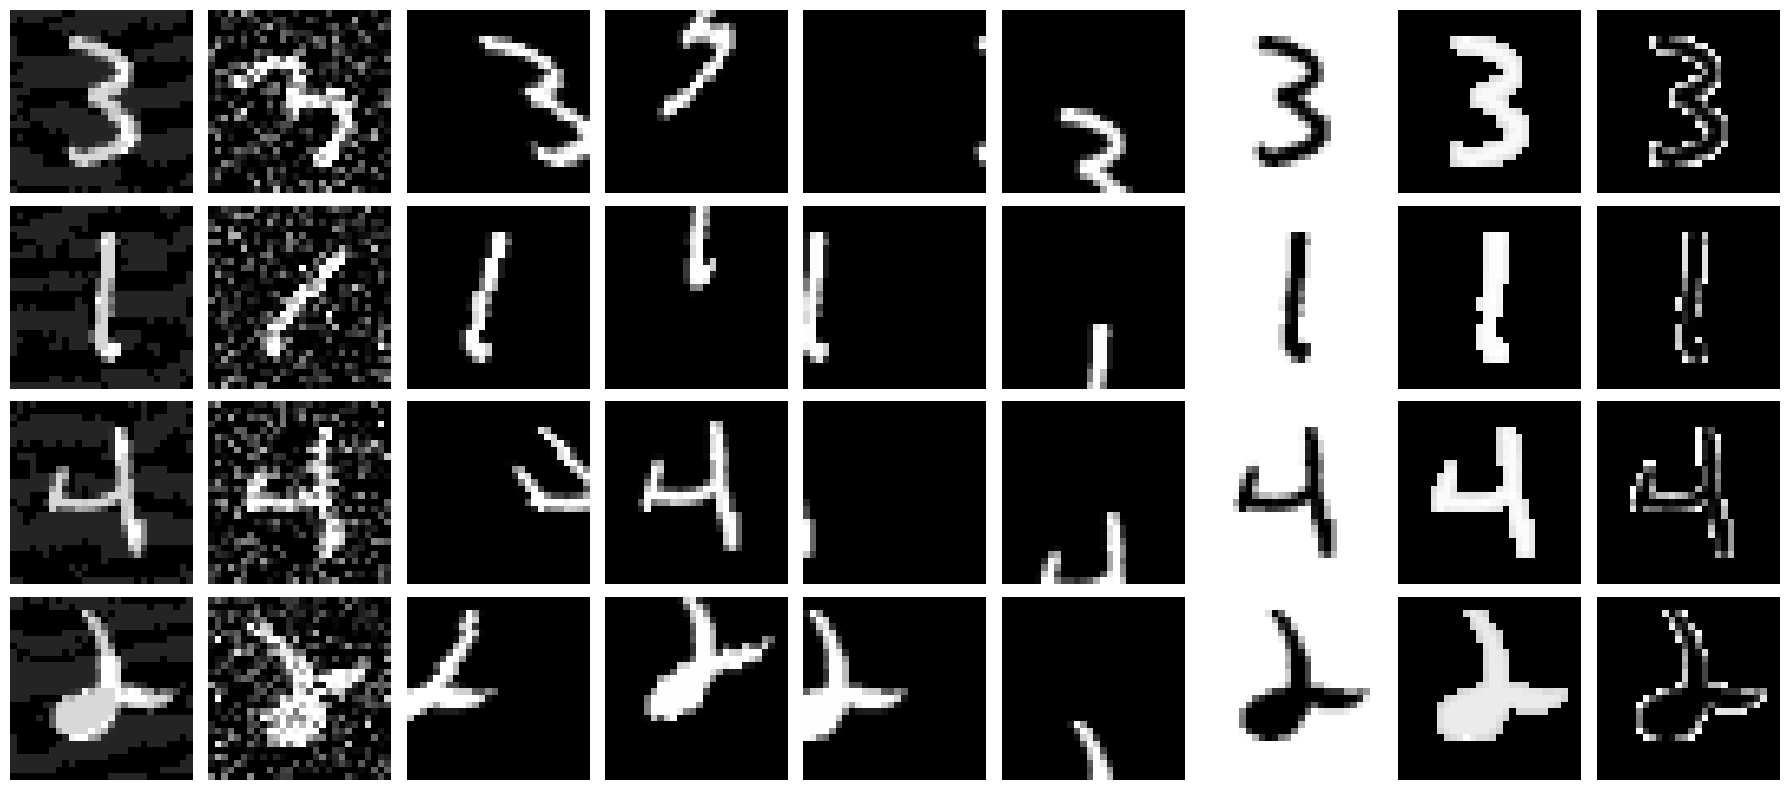

In [21]:
display_images(augs)

### adversarial

In [134]:
model = CNN().to(device)
model.load_state_dict(torch.load('./checkpoints/simple_cnn_mnist.pth'))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(next(model.parameters()).device)

attacks = initialize_all_aggressive_attacks(model)[:9]
n = len(attacks)
n

cpu


9

In [135]:
n_epochs = 10
pi = torch.ones(n)/n
pi.to(device)
all_losses = torch.zeros_like(pi)

adv_loss_history = []
pi_history = [pi]
adv_test_history = []
adv_full_loss_history = []

for i in range(n_epochs):
    pi, logs = train_epoch_adv_v3(model, pi, attacks, optimizer, train_loader, criterion, device, tau = 1, gamma= 1e-1, init_losses = all_losses)
    test_acc = test_epoch_adv(model, attacks, test_loader, device)
    
    adv_test_history.append(test_acc)
    adv_loss_history.append(logs['loss_array'])
    
    all_losses = adv_loss_history[-1][-1]
    
    adv_full_loss_history += [ loss_value.detach().numpy() for loss_value in logs['loss_array']]
    pi_history+=logs['pi_array']
adv_full_loss_history = np.array(adv_full_loss_history)

pi_history = np.array([pi.detach().numpy() for pi in pi_history])
torch.save(model.state_dict(), f'./checkpoints/simple_cnn_mnist_adversarial_{n}_attacks.pth')

100%|██████████| 157/157 [00:07<00:00, 22.26it/s]


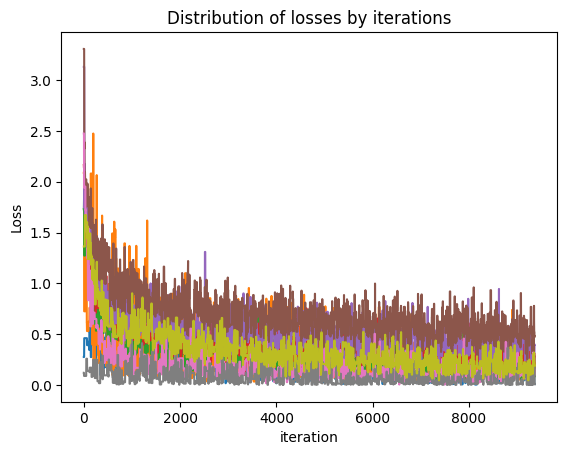

In [136]:
# plt.bar(np.arange(n), adv_full_loss_history.mean(axis = 0))
# plt.title('Mean loss by iterations ')
# plt.show()

plt.plot(adv_full_loss_history)

plt.title(r'Distribution of losses by iterations')
plt.ylabel(r'Loss')
plt.xlabel('iteration')
plt.show()

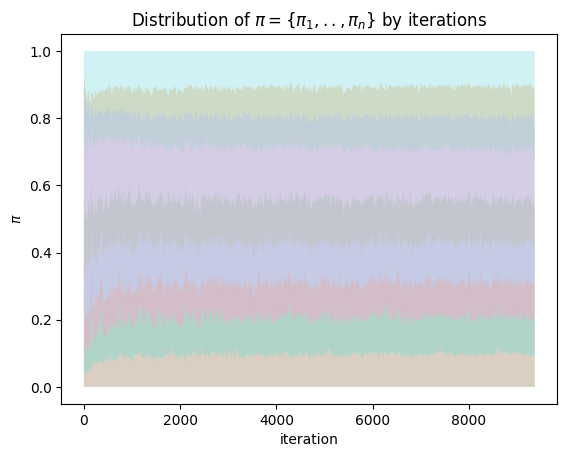

In [137]:
for i in range(len(pi_history[0]) + 1):
    plt.fill_between(np.arange(len(pi_history)), pi_history[:,:i].sum(axis=-1), pi_history[:,:i-1].sum(axis=-1) , alpha=0.2, label = str(i) + " attack")
    # plt.plot(pi_history[:,:i].sum(axis=-1))
plt.title(r'Distribution of $\pi = \{ \pi_1,.., \pi_n \}$ by iterations')
# plt.xticks([])
# plt.yticks([])
plt.ylabel(r'$\pi$')
plt.xlabel('iteration')
# plt.legend()
plt.show()

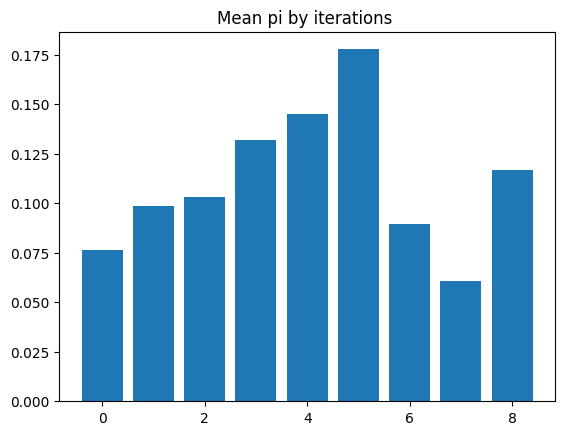

In [138]:
plt.bar(np.arange(n), pi_history[:1000].mean(axis = 0))
plt.title('Mean pi by iterations ')
plt.show()

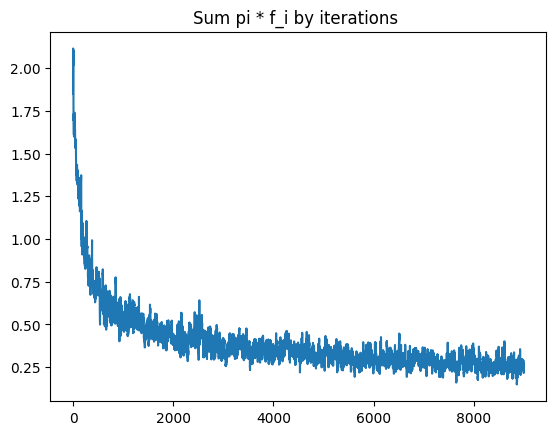

In [139]:
plt.plot(np.sum(pi_history[:900*n_epochs]*adv_full_loss_history[:900*n_epochs], axis = -1))
plt.title('Sum pi * f_i by iterations ')
plt.show()

In [39]:
def kl_divergence(p, q):
    return np.sum(p * np.log(p / q))

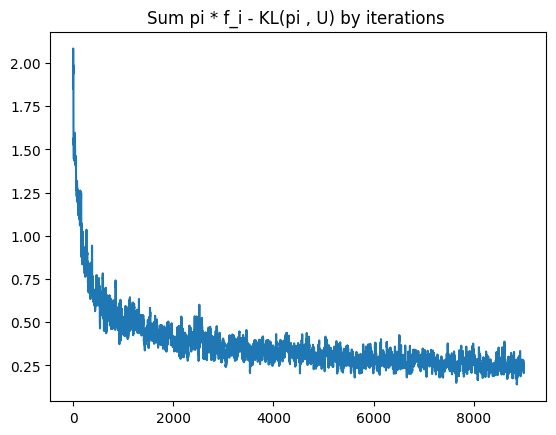

In [141]:
Kl_divs = np.array([kl_divergence(pi , np.ones_like(pi) / len(pi)) for pi in pi_history])
plt.plot(np.sum(pi_history[:900*n_epochs]*adv_full_loss_history[:900*n_epochs], axis = -1)  - Kl_divs[:900*n_epochs] )
plt.title('Sum pi * f_i - KL(pi , U) by iterations ')
plt.show()


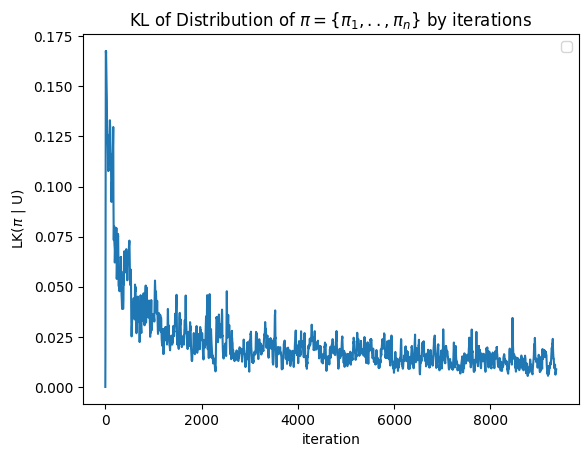

In [142]:
Kl_divs = [kl_divergence(pi , np.ones_like(pi) / len(pi)) for pi in pi_history]
plt.plot(Kl_divs)
plt.title(r'KL of Distribution of $\pi = \{ \pi_1,.., \pi_n \}$ by iterations')
plt.ylabel(r'LK($\pi$ | U)')
plt.xlabel('iteration')
plt.legend()
plt.show()

## default

In [86]:
model = CNN().to(device)
model.load_state_dict(torch.load('./checkpoints/simple_cnn_mnist.pth'))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(next(model.parameters()).device)

attacks = initialize_all_aggressive_attacks(model)[:9]
n = len(attacks)
n

cpu


9

In [87]:
n_epochs = 10
pi = torch.ones(n)/n
pi.to(device)
all_losses = torch.zeros_like(pi)

default_loss_history = []
default_test_history = []

for i in range(n_epochs):
    pi, logs = train_epoch_adv_v3(model, pi, attacks, optimizer, train_loader, criterion, device, tau = 1, gamma= 1e-1, init_losses = all_losses, default = True)
    test_acc = test_epoch_adv(model, attacks, test_loader, device)
    
    default_test_history.append(test_acc)
    default_loss_history.append(logs['loss_array'])
    
torch.save(model.state_dict(), f'./checkpoints/simple_cnn_mnist_default_{n}_attacks.pth')

100%|██████████| 157/157 [00:07<00:00, 22.31it/s]


## comparison

In [145]:
adv_test_history = np.array(adv_test_history)
default_test_history = np.array(default_test_history)

In [105]:
mask = adv_test_history > default_test_history
mask[-1,:]

array([ True,  True, False,  True, False,  True,  True,  True, False])

In [106]:
pi_history[:1000].mean(axis = 0)

array([0.09435874, 0.10949488, 0.10849858, 0.12783821, 0.12357813,
       0.14232035, 0.09915584, 0.08448092, 0.11027446], dtype=float32)

In [107]:
indices = np.argsort(pi_history[:1000].mean(axis = 0))[-5:]
indices

array([1, 8, 4, 3, 5])

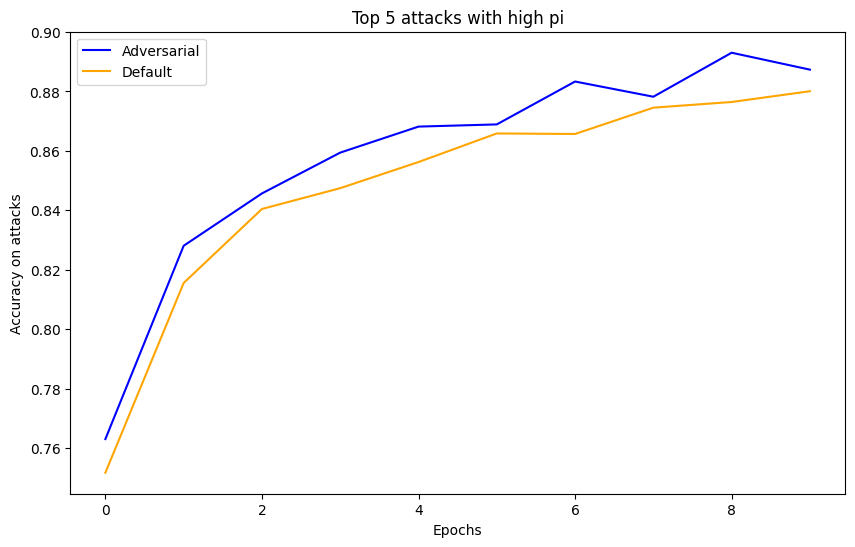

In [143]:

plt.figure(figsize=(10, 6))
# i = [1,2,3,4,6,7,8,9,10,11]
i = indices
# i = np.arange(12)
plt.plot(np.array(adv_test_history)[:,i].mean(axis=-1), label='Adversarial', color='blue')
plt.plot(np.array(default_test_history)[:,i].mean(axis=-1), label='Default', color='orange')

# Настройки графика
plt.title(f'Top 5 attacks with high pi')
plt.ylabel('Accuracy on attacks')
plt.xlabel('Epochs')
plt.legend()
plt.show()

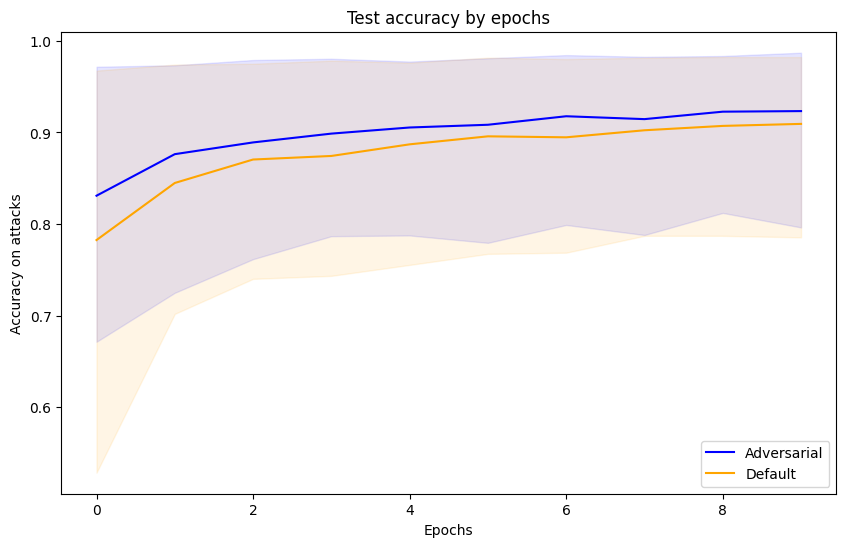

In [146]:
adv_mean = np.array(adv_test_history).mean(axis=-1)
adv_var = np.array(adv_test_history).var(axis=-1)

default_mean = np.array(default_test_history).mean(axis=-1)
default_var = np.array(default_test_history).var(axis=-1)

# Создание графика
plt.figure(figsize=(10, 6))

# График среднего значения
plt.plot(adv_mean, label='Adversarial', color='blue')
plt.plot(default_mean, label='Default', color='orange')

# Добавление области дисперсии
# plt.fill_between(np.arange(len(adv_mean)), adv_mean - np.sqrt(adv_var), adv_mean + np.sqrt(adv_var), color='blue', alpha=0.1)
# plt.fill_between(np.arange(len(default_mean)), default_mean - np.sqrt(default_var), default_mean + np.sqrt(default_var), color='orange', alpha=0.1)

plt.fill_between(np.arange(len(adv_mean)), adv_test_history.min(axis=-1), adv_test_history.max(axis=-1), color='blue', alpha=0.1)
plt.fill_between(np.arange(len(default_mean)), default_test_history.min(axis=-1), default_test_history.max(axis=-1) , color='orange', alpha=0.1)

# Настройки графика
plt.title('Test accuracy by epochs')
plt.ylabel('Accuracy on attacks')
plt.xlabel('Epochs')
plt.legend()
plt.show()

## Experiments with different seeds

In [22]:
seeds = np.arange(10)


max_iter = 920*len(seeds) # adv_full_loss have different sizes

# Инициализация списков для хранения средних значений по сидам
adv_test_means = []
default_test_means = []
adv_loss_means = []
default_loss_means = []

# Перебор сидов и загрузка данных
for seed in seeds:
    # Загрузка данных
    adv_test_history = np.load(f'./checkpoints/exp_1/adv_test_history_seed_{seed}.npy')
    adv_full_loss_history = np.load(f'./checkpoints/exp_1/adv_full_loss_history_seed_{seed}.npy')
    default_test_history = np.load(f'./checkpoints/exp_1/default_test_history_seed_{seed}.npy')
    default_full_loss_history = np.load(f'./checkpoints/exp_1/default_full_loss_history_seed_{seed}.npy')

    # Вычисление средних значений по последней размерности
    adv_test_mean = np.mean(adv_test_history, axis=-1)
    adv_loss_mean = np.mean(adv_full_loss_history[:max_iter], axis=-1)
    default_test_mean = np.mean(default_test_history, axis=-1)
    default_loss_mean = np.mean(default_full_loss_history[:max_iter], axis=-1)
    # print(adv_test_mean.shape)
    # print(adv_loss_mean.shape)

    # Добавление средних значений в списки
    adv_test_means.append(adv_test_mean)
    adv_loss_means.append(adv_loss_mean)
    default_test_means.append(default_test_mean)
    default_loss_means.append(default_loss_mean)



adv_test_means = np.array(adv_test_means)
adv_loss_means = np.array(adv_loss_means)
default_test_means = np.array(default_test_means)
default_loss_means = np.array(default_loss_means)

# Вычисление глобальных средних значений и стандартного отклонения
adv_mean_test, adv_std_test = np.mean(adv_test_means ,axis = 0 ), np.std(adv_test_means,axis = 0)
adv_mean_loss, adv_std_loss = np.mean(adv_loss_means,axis = 0), np.std(adv_loss_means,axis = 0)
default_mean_test, default_std_test = np.mean(default_test_means,axis = 0), np.std(default_test_means,axis = 0)
default_mean_loss, default_std_loss = np.mean(default_loss_means,axis = 0), np.std(default_loss_means,axis = 0)

# Вывод результатов
print("Adversarial Test Mean:", adv_mean_test.shape , "Std:", adv_std_test.shape)
print("Adversarial Loss Mean:", adv_mean_loss.shape, "Std:", adv_std_loss.shape)
print("Default Test Mean:", default_mean_test.shape, "Std:", default_std_test.shape)
print("Default Loss Mean:", default_mean_loss.shape, "Std:", default_std_loss.shape)

Adversarial Test Mean: (10,) Std: (10,)
Adversarial Loss Mean: (9200,) Std: (9200,)
Default Test Mean: (10,) Std: (10,)
Default Loss Mean: (9200,) Std: (9200,)


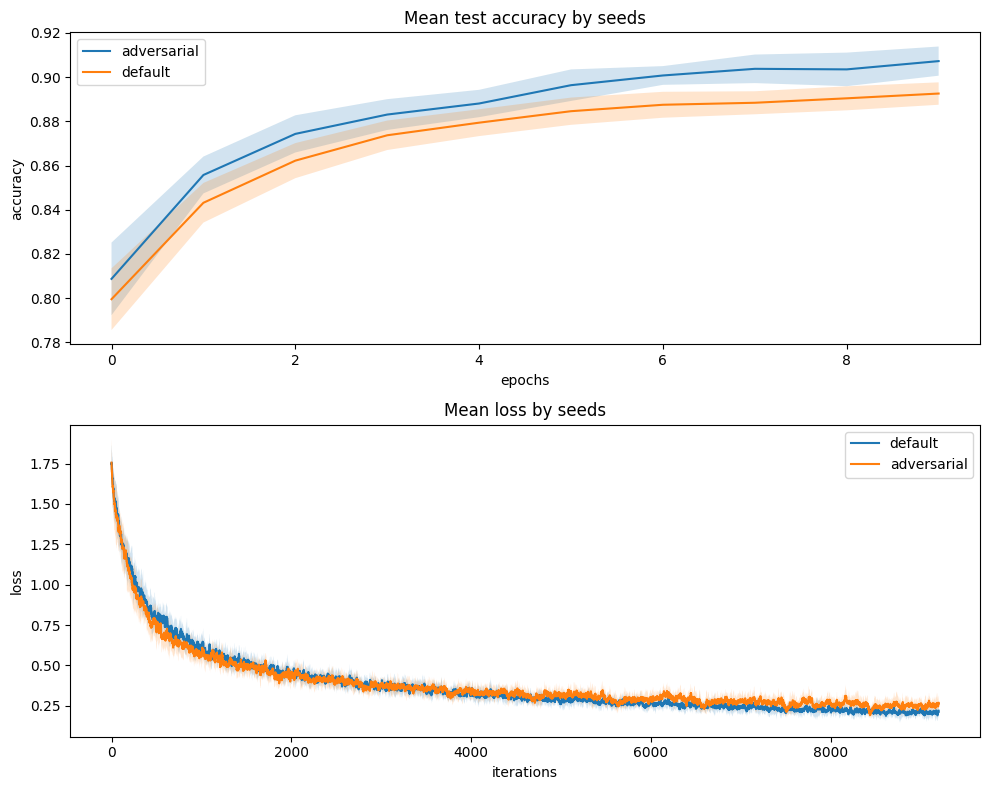

In [23]:
plt.figure(figsize=(10, 8))

# Построение графика для Adversarial Test
plt.subplot(2, 1, 1)

plt.plot(seeds, adv_mean_test, label='adversarial')
plt.fill_between(seeds, adv_mean_test - adv_std_test, adv_mean_test + adv_std_test, alpha=0.2)
plt.plot(seeds, default_mean_test, label='default')
plt.fill_between(seeds, default_mean_test - default_std_test, default_mean_test + default_std_test, alpha=0.2)

plt.title('Mean test accuracy by seeds')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

# Построение графика для Default Test
plt.subplot(2, 1, 2)
plt.plot(default_mean_loss, label='default')
plt.fill_between(range(default_mean_loss.shape[0]),default_mean_loss - default_std_loss, default_mean_loss + default_std_loss, alpha=0.2)
plt.plot(adv_mean_loss, label='adversarial')
plt.fill_between(range(adv_mean_loss.shape[0]), adv_mean_loss - adv_std_loss, adv_mean_loss + adv_std_loss, alpha=0.2)
plt.title('Mean loss by seeds')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.legend()

# Отображение графиков
plt.tight_layout()
plt.show()

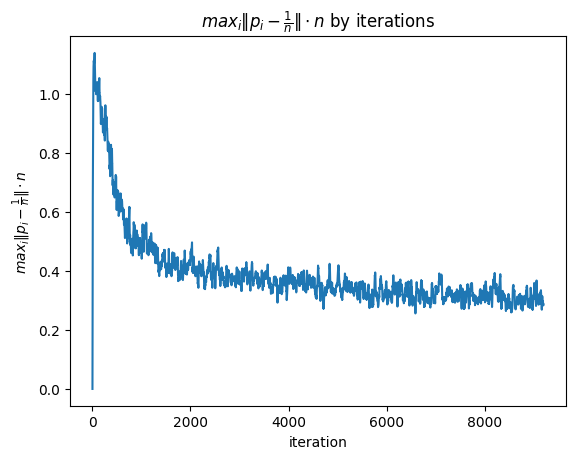

In [27]:
seeds = np.arange(10)
all_values = []
for seed in seeds:
    pi_history = np.load(f'./checkpoints/exp_1/pi_history_seed_{seed}.npy') 
    pi_history = pi_history[:max_iter]
    value = np.max(np.abs(pi_history - 1/pi_history.shape[1]) * pi_history.shape[1] , axis = -1)
    all_values.append(value)
all_values = np.array(all_values)

mean_values = all_values.mean(axis=0)
std_values = all_values.std(axis=0)


plt.plot(mean_values )
plt.fill_between(mean_values + std_values , mean_values - std_values , alpha=0.2)
plt.title(r'$max_i \| p_i - \frac{1}{n} \| \cdot n $ by iterations')
plt.ylabel(r'$max_i \| p_i - \frac{1}{n} \| \cdot n $')
plt.xlabel('iteration')
plt.show()

In [50]:
def kl_divergence(p, q):
    return p * np.log(p / q)

## Out of distribution exps

In [118]:
seeds = np.arange(1)


max_iter = 920*len(seeds) # adv_full_loss have different sizes

# Инициализация списков для хранения средних значений по сидам
adv_test_means = []
default_test_means = []
adv_loss_means = []
default_loss_means = []
pi_histories = []

fake_indices = np.load(f'./checkpoints/exp_2/fake_indices.npy')


# Перебор сидов и загрузка данных
for seed in seeds:
    pi_history = np.load(f'./checkpoints/exp_2/pi_history_seed_{seed}.npy')
    pi_histories.append(pi_history)
    # Загрузка данных
    adv_test_history = np.load(f'./checkpoints/exp_2/adv_test_history_seed_{seed}.npy')
    adv_full_loss_history = np.load(f'./checkpoints/exp_2/adv_full_loss_history_seed_{seed}.npy')
    default_test_history = np.load(f'./checkpoints/exp_2/default_test_history_seed_{seed}.npy')
    default_full_loss_history = np.load(f'./checkpoints/exp_2/default_full_loss_history_seed_{seed}.npy')

    # Вычисление средних значений по последней размерности
    adv_test_mean = np.mean(adv_test_history, axis=-1)
    adv_loss_mean = np.mean(adv_full_loss_history[:max_iter], axis=-1)
    default_test_mean = np.mean(default_test_history, axis=-1)
    default_loss_mean = np.mean(default_full_loss_history[:max_iter], axis=-1)
    # print(adv_test_mean.shape)
    # print(adv_loss_mean.shape)

    # Добавление средних значений в списки
    adv_test_means.append(adv_test_mean)
    adv_loss_means.append(adv_loss_mean)
    default_test_means.append(default_test_mean)
    default_loss_means.append(default_loss_mean)



adv_test_means = np.array(adv_test_means)
adv_loss_means = np.array(adv_loss_means)
default_test_means = np.array(default_test_means)
default_loss_means = np.array(default_loss_means)

# Вычисление глобальных средних значений и стандартного отклонения
adv_mean_test, adv_std_test = np.mean(adv_test_means ,axis = 0 ), np.std(adv_test_means,axis = 0)
adv_mean_loss, adv_std_loss = np.mean(adv_loss_means,axis = 0), np.std(adv_loss_means,axis = 0)
default_mean_test, default_std_test = np.mean(default_test_means,axis = 0), np.std(default_test_means,axis = 0)
default_mean_loss, default_std_loss = np.mean(default_loss_means,axis = 0), np.std(default_loss_means,axis = 0)

# Вывод результатов
print("Adversarial Test Mean:", adv_mean_test.shape , "Std:", adv_std_test.shape)
print("Adversarial Loss Mean:", adv_mean_loss.shape, "Std:", adv_std_loss.shape)
print("Default Test Mean:", default_mean_test.shape, "Std:", default_std_test.shape)
print("Default Loss Mean:", default_mean_loss.shape, "Std:", default_std_loss.shape)

Adversarial Test Mean: () Std: ()
Adversarial Loss Mean: () Std: ()
Default Test Mean: () Std: ()
Default Loss Mean: () Std: ()


In [119]:
adv_full_loss_history.shape


(8443,)

In [120]:
# fake_train_dataset, fake_test_dataset, fake_train_loader, fake_test_loader = MNIST_v3_fake()

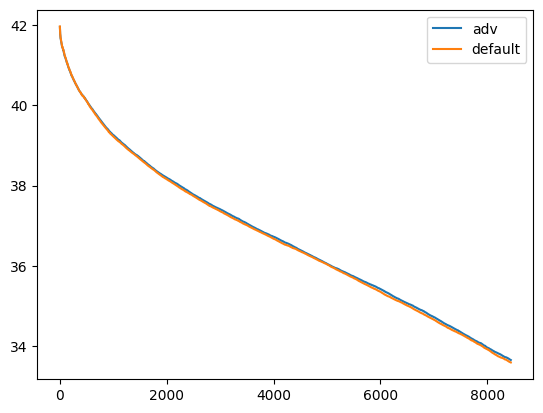

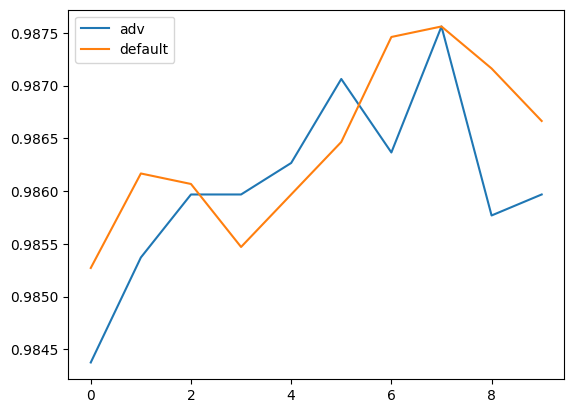

In [121]:
plt.plot(adv_full_loss_history, label = 'adv')
plt.plot(default_full_loss_history, label = 'default')
plt.legend()
plt.show()

plt.plot(adv_test_history, label = 'adv')
plt.plot(default_test_history, label = 'default')
plt.legend()
plt.show()

In [122]:
pi_history.shape

(11, 60000)

[]

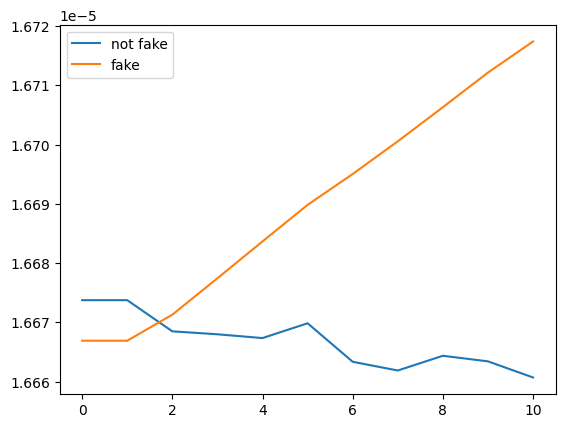

In [123]:
plt.plot(pi_history[:,list(set(np.arange(pi_history.shape[1])) - set(fake_indices))].mean(axis=-1) , label = 'not fake')
plt.plot(pi_history[:,fake_indices].mean(axis=-1) , label = 'fake')

plt.legend()
plt.plot()

In [127]:
for i in range(10): 
    sorted_indices = np.argsort(pi_history[i])

    print(len(list(set(sorted_indices[len(sorted_indices)//2:]).intersection(set(fake_indices)))) / len(fake_indices) , \
    len(
        list(
            set(np.arange(pi_history.shape[1]//2, pi_history.shape[1])).intersection(set(fake_indices))
        )
    ) / len(fake_indices) )

0.50239629813254 0.49760370186745995
0.6311353495290035 0.49760370186745995
0.6347711122128574 0.49760370186745995
0.6341100644521567 0.49760370186745995
0.6336142786316311 0.49760370186745995
0.6341100644521567 0.49760370186745995
0.6354321599735581 0.49760370186745995
0.6370847793753098 0.49760370186745995
0.6357626838539084 0.49760370186745995
0.6392331845975872 0.49760370186745995


In [125]:
len(pi_history[i][list(set(np.arange(pi_history.shape[1])) - set(fake_indices))])

53949

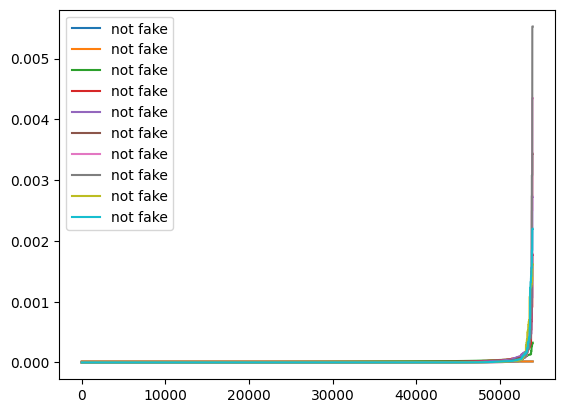

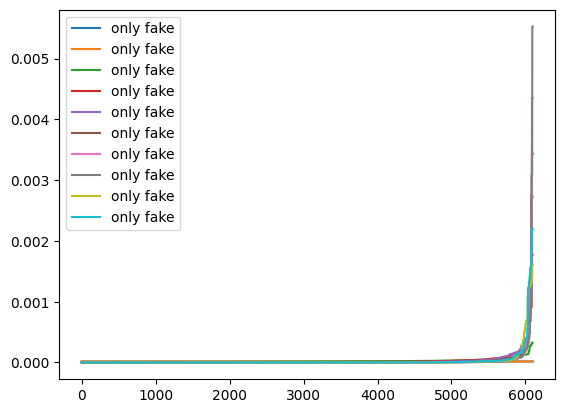

In [117]:
for i in range(10):
    plt.plot(sorted(pi_history[i][list(set(np.arange(pi_history.shape[1])) - set(fake_indices))]) , label = 'not fake')
plt.legend()
plt.show()

for i in range(10):
    plt.plot(sorted(pi_history[i][fake_indices]) , label = 'only fake')
plt.legend()
plt.show()

In [160]:
train_dataset, test_dataset, train_loader, test_loader = MNIST_v3_fake(p = 0.1)
print(len(train_dataset))
fake_indices = np.array(list(train_dataset.get_fake_indices()))

60000


In [162]:
all_indices = np.arange(len(train_dataset))
sorted_indices = np.argsort(pi_history[-1])
indices_to_remove = sorted_indices[len(sorted_indices)//2:]

new_train_dataset = deepcopy(train_dataset)


new_train_dataset.filter_indices(indices_to_remove)

new_train_loader = DataLoader(new_train_dataset, batch_size=64, shuffle=True)


In [168]:
for i in range(10):
    print(new_train_dataset[i][2:])

(0, False)
(1, False)
(2, False)
(3, True)
(4, False)
(5, False)
(6, True)
(7, False)
(8, False)
(9, False)


In [137]:
j = 0 
for traindata in new_train_loader:
    train_inputs, train_labels, train_indices, fake_indices = traindata
    j += 1

469


In [139]:
train_dataset[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [136]:
# train_inputs, 
train_labels, train_indices, fake_indices

(tensor([2, 2, 7, 1, 1, 0, 1, 6, 7, 0, 6, 4, 0, 6, 7, 6, 2, 1, 9, 3, 8, 5, 7, 5,
         0, 4, 1, 7, 0, 8, 3, 4, 8, 1, 0, 2, 0, 7, 2, 4, 1, 4, 9, 1, 0, 2, 4, 3,
         8, 7, 1, 7, 7, 5, 4, 2, 5, 7, 9, 4, 2, 8, 3, 5]),
 tensor([21004, 12299, 20866, 22621, 14698, 59433,  3900, 41676, 30462, 39446,
         54915,  9282,  9742, 48199, 33885, 31672, 24182, 40210, 10414, 22415,
         39167, 23689, 18257, 25096, 46818, 46643, 41474, 58679, 11532, 32553,
         25590, 39471, 53240, 37670,   473, 31146, 24717, 59792, 58032, 52631,
         37081, 36659, 11991, 57989, 53424, 24864, 24855, 57698, 43372, 24372,
         49473, 25314, 50732, 43820, 10396, 30752, 37582, 17300, 13235, 25737,
         13905, 30781, 58800, 22599]),
 tensor([ True, False, False, False, False, False, False, False, False, False,
          True, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False,  True, False, False,
         False, False, False,

In [173]:
seeds = np.arange(1)


max_iter = 920*len(seeds) # adv_full_loss have different sizes

# Инициализация списков для хранения средних значений по сидам
adv_test_means = []
default_test_means = []
adv_loss_means = []
default_loss_means = []

adv_test_means_cold = []
default_test_means_cold = []
adv_loss_means_cold = []
default_loss_means_cold = []

pi_histories = []

fake_indices = np.load(f'./checkpoints/exp_2/fake_indices.npy')


# Перебор сидов и загрузка данных
for seed in seeds:
    pi_history = np.load(f'./checkpoints/exp_2/pi_history_seed_{seed}.npy')
    pi_histories.append(pi_history)
    # Загрузка данных
    adv_test_history = np.load(f'./checkpoints/exp_2/adv_test_history_seed_{seed}.npy')
    adv_full_loss_history = np.load(f'./checkpoints/exp_2/adv_full_loss_history_seed_{seed}.npy')
    default_test_history = np.load(f'./checkpoints/exp_2/default_test_history_seed_{seed}.npy')
    default_full_loss_history = np.load(f'./checkpoints/exp_2/default_full_loss_history_seed_{seed}.npy')

    adv_test_history_cold = np.load(f'./checkpoints/exp_2/adv_test_history_cold_seed_{seed}.npy')
    adv_full_loss_history_cold = np.load(f'./checkpoints/exp_2/adv_full_loss_history_cold_seed_{seed}.npy')
    default_test_history_cold = np.load(f'./checkpoints/exp_2/default_test_history_cold_seed_{seed}.npy')
    default_full_loss_history_cold = np.load(f'./checkpoints/exp_2/default_full_loss_history_cold_seed_{seed}.npy')

    # Вычисление средних значений по последней размерности
    adv_test_mean = np.mean(adv_test_history, axis=-1)
    adv_loss_mean = np.mean(adv_full_loss_history[:max_iter], axis=-1)
    default_test_mean = np.mean(default_test_history, axis=-1)
    default_loss_mean = np.mean(default_full_loss_history[:max_iter], axis=-1)

    adv_test_mean_cold = np.mean(adv_test_history_cold, axis=-1)
    adv_loss_mean_cold = np.mean(adv_full_loss_history_cold[:max_iter], axis=-1)
    default_test_mean_cold = np.mean(default_test_history_cold, axis=-1)
    default_loss_mean_cold = np.mean(default_full_loss_history_cold[:max_iter], axis=-1)

    # Добавление средних значений в списки
    adv_test_means.append(adv_test_mean)
    adv_loss_means.append(adv_loss_mean)
    default_test_means.append(default_test_mean)
    default_loss_means.append(default_loss_mean)

    adv_test_means_cold.append(adv_test_mean_cold)
    adv_loss_means_cold.append(adv_loss_mean_cold)
    default_test_means_cold.append(default_test_mean_cold)
    default_loss_means_cold.append(default_loss_mean_cold)


adv_test_means = np.array(adv_test_means)
adv_loss_means = np.array(adv_loss_means)
default_test_means = np.array(default_test_means)
default_loss_means = np.array(default_loss_means)

adv_test_means_cold = np.array(adv_test_means_cold)
adv_loss_means_cold = np.array(adv_loss_means_cold)
default_test_means_cold = np.array(default_test_means_cold)
default_loss_means_cold = np.array(default_loss_means_cold)

# Вычисление глобальных средних значений и стандартного отклонения
adv_mean_test, adv_std_test = np.mean(adv_test_means ,axis = 0 ), np.std(adv_test_means,axis = 0)
adv_mean_loss, adv_std_loss = np.mean(adv_loss_means,axis = 0), np.std(adv_loss_means,axis = 0)
default_mean_test, default_std_test = np.mean(default_test_means,axis = 0), np.std(default_test_means,axis = 0)
default_mean_loss, default_std_loss = np.mean(default_loss_means,axis = 0), np.std(default_loss_means,axis = 0)

adv_mean_test_cold, adv_std_test_cold = np.mean(adv_test_means_cold ,axis = 0 ), np.std(adv_test_means_cold,axis = 0)
adv_mean_loss_cold, adv_std_loss_cold = np.mean(adv_loss_means_cold,axis = 0), np.std(adv_loss_means_cold,axis = 0)
default_mean_test_cold, default_std_test_cold = np.mean(default_test_means_cold,axis = 0), np.std(default_test_means_cold,axis = 0)
default_mean_loss_cold, default_std_loss_cold = np.mean(default_loss_means_cold,axis = 0), np.std(default_loss_means_cold,axis = 0)

# Вывод результатов
print("Adversarial Test Mean Cold:", adv_mean_test_cold.shape , "Std:", adv_std_test_cold.shape)
print("Adversarial Loss Mean Cold:", adv_mean_loss_cold.shape, "Std:", adv_std_loss_cold.shape)
print("Default Test Mean Cold:", default_mean_test_cold.shape, "Std:", default_std_test_cold.shape)
print("Default Loss Mean Cold:", default_mean_loss_cold.shape, "Std:", default_std_loss_cold.shape)

print("Adversarial Test Mean:", adv_mean_test.shape , "Std:", adv_std_test.shape)
print("Adversarial Loss Mean:", adv_mean_loss.shape, "Std:", adv_std_loss.shape)
print("Default Test Mean:", default_mean_test.shape, "Std:", default_std_test.shape)
print("Default Loss Mean:", default_mean_loss.shape, "Std:", default_std_loss.shape)

Adversarial Test Mean Cold: () Std: ()
Adversarial Loss Mean Cold: () Std: ()
Default Test Mean Cold: () Std: ()
Default Loss Mean Cold: () Std: ()
Adversarial Test Mean: () Std: ()
Adversarial Loss Mean: () Std: ()
Default Test Mean: () Std: ()
Default Loss Mean: () Std: ()


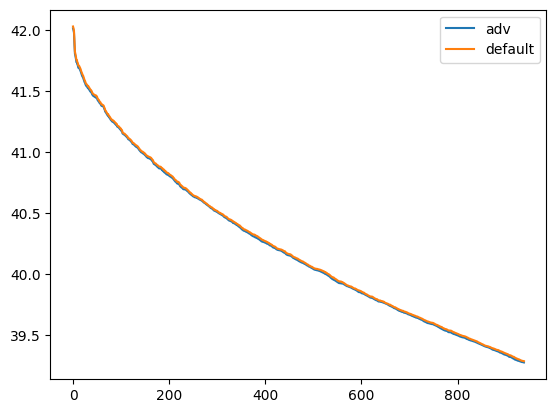

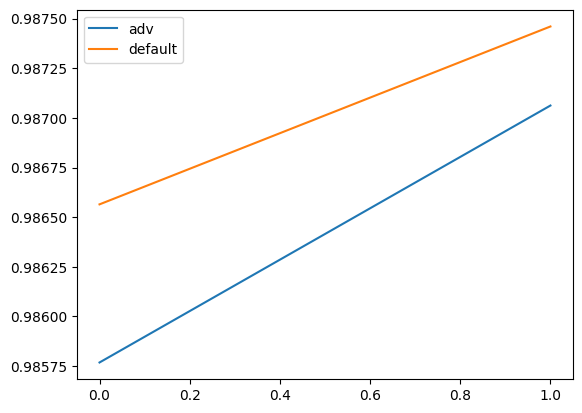

In [174]:
plt.plot(adv_full_loss_history_cold, label = 'adv')
plt.plot(default_full_loss_history_cold, label = 'default')
plt.legend()
plt.show()

plt.plot(adv_test_history_cold, label = 'adv')
plt.plot(default_test_history_cold, label = 'default')
plt.legend()
plt.show()

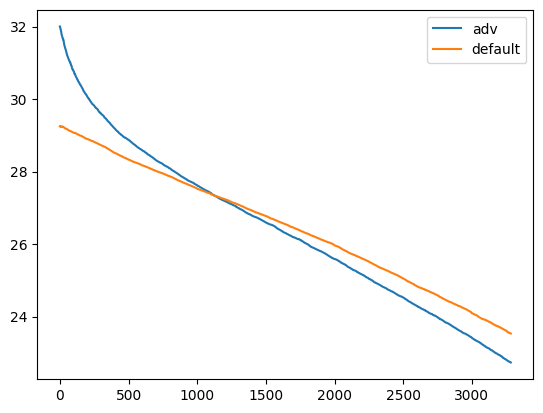

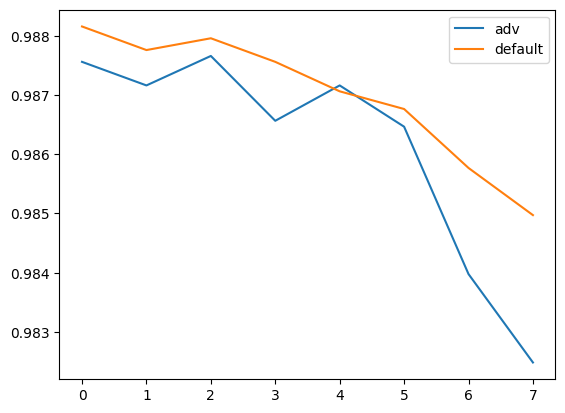

In [175]:
plt.plot(adv_full_loss_history, label = 'adv')
plt.plot(default_full_loss_history, label = 'default')
plt.legend()
plt.show()

plt.plot(adv_test_history, label = 'adv')
plt.plot(default_test_history, label = 'default')
plt.legend()
plt.show()